# Cournot competition with uncertainty about market demand

Firms compete in Cournot competition (i.e. in quantities) with differentiated products, where market demand is 

$$ P = \max ( a- Q, 0 ), \quad Q \equiv q_1 + q_2. $$

The problem is that $a$ is uncertain. The firms differ in the information they are provided. 
1. Firm 1 knows $a$ when choosing its quantity, 
2. Firm 2 does not but knows its distribution (and knows that firm 1 observes $a$). 

Specifically, let's assume that $a$ takes values 

$$ a \in A \equiv \{ 0.1, 0.5, 1.0, 2.0 \} \text{ with equal probability. } $$

That is, $\Pr(a = 0.5) = \frac{1}{4}$, for example. 

The firms' strategies are: 
1. Firm 1: a quantity, $q_1(a)$, for each $a \in A$: so four numbers. The values are set to be a best response to $q_1$, i.e. solving 
$$ BR_1(q_2; a) = \arg \max_{q_1 \in [0;1]} pi_1(q_1, q_2; a), \quad \forall a \in A. $$
2. Firm 2: a single quantity, chosen to solve
$$ BR_2(q_1) = \arg \max_{q_2 \in [0;1]} \mathbb{E}_a [\pi_2(q_1, q_2; a)] = \sum_{a \in A} \frac{1}{4} \pi_i(q_1, q_2; a). $$


# Loading modules 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Cournot model 

In [2]:
c = 0.1
q_min = 0.0
q_max = 1.0

# uncertainty about demand condition 
aa = np.array([0.1, 0.5, 1.0, 2.0])
Na = aa.size
probs = np.ones((Na,)) / Na # equi probable 


def price(q1, q2, a, b=1.): 
    Q = q1+q2
    P = a - b*Q
    return np.fmax(P, 0.0)

def profit1(q1, q2, a):
    P = price(q1, q2, a)
    return (P-c)*q1

def profit2(q1, q2, a):
    P = price(q1, q2, a)
    return (P-c)*q2

Plotting the *ex post* payoff function (i.e. after $a$ has been realized).

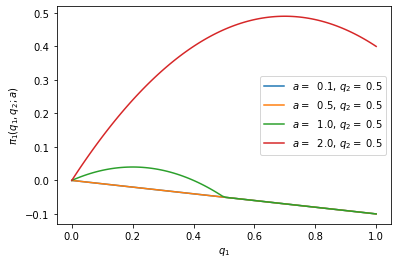

In [3]:
q_ = np.linspace(q_min, q_max, 100)

for a in aa: 
    for q2 in np.array([0.5]): 
        plt.plot(q_, profit1(q_, q2, a), label=f'$a=$ {a:4.1f}, $q_2= ${q2:4.1f}')
plt.legend()
plt.xlabel('$q_1$'); plt.ylabel('$\pi_1(q_1, q_2; a)$');

# Expected profits

For firm 1, there is no uncertainty since it observes $a$. 

For firm 2, it must compute the expected profit wrt. $a$: 

$$ \mathbb{E}_a[\pi_2(q_1,q_2; a)] = \sum_{a \in A} \Pr(a) \pi_2(q_1,q_2; a). $$

In [4]:
def Eprofit2(q1s, q2, aa): 
    assert q1s.size == aa.size, f'firm 1''s strategy is one quantity for every a'
    pis = np.empty((Na,))
    for i, (a,q1) in enumerate(zip(aa, q1s)):
        pis[i] = np.mean(profit2(q1, q2, a))
    return pis.mean()

## Plot (interrim) expected profits 

Note that there are *"wriggles"* in the expected profit function. These occur every time we cross the top point of one of the four individual parabolas that make up the *ex post* profit functions that we are taking the expectation (i.e. averaging) over. 

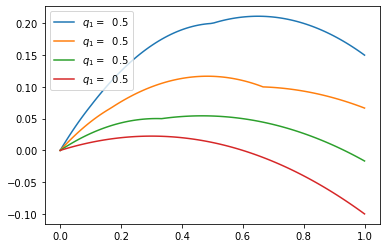

In [5]:
q2_ = np.linspace(q_min, q_max, 100)
q1_ = np.linspace(q_min, q_max, 4)
for q1 in q1_:
    s1 = q1 * np.ones((Na,)) # if 1's strategy is to play q1 always, regardless of a
    pi = np.array([Eprofit2(s1,q2,aa) for q2 in q2_])
    plt.plot(q2_, pi, label=f'$q_1=$ {q2:4.1f}')
plt.legend();

# Best response (BR) functions 

Different for the two firms: 
1. Firm 1 best responds to the scalar quantity of firm 2 as well as a concrete realization of $a$, 
2. Firm 2 best responds to the *strategy* of firm 1, which is a quantity for each possible realization of $a$. 

In [6]:
def BR1(q2, a):
    assert np.isscalar(q2), f'q2 must be scalar (firm 2''s strategy)'
    assert np.isscalar(a), f'a must be scalar (the BR is evaluated for the realized value of a)'
    f = lambda q1: -profit1(q1, q2, a)
    res = minimize_scalar(f, bounds=(q_min, q_max), method='bounded')
    return res.x

def BR2(q1): 
    assert not np.isscalar(q1) ,f'Input, q1, must be a strategy for firm 1 and thus a {aa.size}-vector. Got {q1}.' 
    assert q1.size == aa.size, f'Input, q1, must be a strategy for firm 1 and thus a {aa.size}-vector. Got {q1}.'
    f = lambda q2: -Eprofit2(q1, q2, aa)
    res = minimize_scalar(f, bounds=(q_min, q_max), method='bounded')
    return res.x

def BR(q): 
    assert q.size == Na+1, f'There should be {Na+1} quantities in q: {Na} for firm 1 and one for firm 2.'
    br = np.empty(q.shape) # pre-allocate output vector 
    
    q1s = q[:-1]
    q2 = q[-1]
    
    # firm 1 updates conditional on a 
    for i,a in enumerate(aa): 
        br[i] = BR1(q2, a)

    # firm 2 (the last quantity) 
    br[-1] = BR2(q1s)

    return br

Let's test that the functions make sense.

In [7]:
q0 = (q_max - q_min)/2 # just some sensible value for testing 
q2_init = q0
q1_init = q0 * np.ones((Na,))
this_a = aa[-1] # the max value 
print(f'{BR1(q2_init, a=this_a)}')
print(f'{BR2(q1_init)}')
# since the players are symmetric, their best response should be the same. 

0.7000000000000003
0.3999999999999999


# Iterated Best Response 

We will be iterating on the full vector of quantities, $q \in \mathbb{R}^5$: there are 4 quantities for firm 1 and one for firm 2. 

In [8]:
# q = (s_1, s_2), where s_1 is a 4-vector and s_2 is scalar
q_init = np.ones((Na+1,)) * (q_max-q_min)/3. 

In [9]:
def IBR(q_init:np.ndarray, tol=1e-6, max_iter=100, DOPRINT=False) -> np.ndarray: 
    if DOPRINT: 
        print(f'q_init = {q_init.round(2)}')

    q = q_init.copy()
    for i in range(max_iter): 
        q_new = BR(q)
        crit = np.mean((q_new - q)**2)
        if crit < tol: 
            if DOPRINT: 
                print(f'Converged in {i+1} iterations (crit={crit: 6.2g})')
            break
        q = q_new
    return q

qNE = IBR(q_init, DOPRINT=True)
qNE1 = qNE[:-1]
qNE2 = qNE[-1]
print(f'BNE: q1 = {qNE1.round(2)}, q2 = {qNE2.round(2)}')


q_init = [0.33 0.33 0.33 0.33 0.33]
Converged in 9 iterations (crit= 5.9e-07)
BNE: q1 = [0.   0.03 0.28 0.78], q2 = 0.33


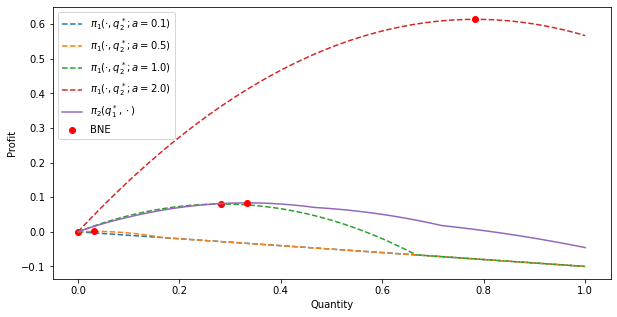

In [10]:
plt.figure(figsize=(10,5))
qq = np.linspace(q_min, q_max, 100)

for a,qNE1_ in zip(aa,qNE1): 
    pi1 = np.array([profit1(q1, qNE2,a) for q1 in qq])
    plt.plot(qq, pi1, '--', label=f'$\pi_1(\cdot, q_2^*; a={a})$')
    plt.plot(qNE1_, profit1(qNE1_, qNE2,a), 'or');

pi2 = np.array([Eprofit2(qNE1, q2, aa) for q2 in qq])
plt.plot(qq, pi2, '-', label=f'$\pi_2(q_1^*, \cdot)$')

plt.plot(qNE2, Eprofit2(qNE1, qNE2, aa), 'or', label=f'BNE') # the functions are symmetrical

plt.legend();plt.ylabel('Profit');plt.xlabel('Quantity');


The two players profit functions are on top of each other because the game is symmetric. 